<center><h5>CSCI 6709 - Software-Defined Networking</h5></center>
<center><h5>Project : Performance Evaluation of ML Models in Resource Constraint Devices </h5></center>
<center><h5>Performance of different models of handwritten digit recognition dataset on different edge devices</h5></center>
<center><h5>Name : Yixiao Yuan</h5></center>

This experiment aims to develop multiple neural network models for the MNIST dataset using TensorFlow, and then optimize and fine-tune them to obtain the best model. The models are evaluated on a test dataset, and a confusion matrix and classification report are generated.

To make the models run better on edge devices, we optimize them with pruning, quantization, and other techniques. The models are then converted to TensorFlow Lite models and OpenVINO IR models and tested on hardware platforms such as Raspberry Pi, Intel Neural Compute Stick, and smart NICs. The models read the transformed test dataset and perform inference, while the run status and results are recorded in numpy binary format files. These files are imported into a computer to generate reports.

Finally, all experimental results are analyzed, and graphs are created to summarize the findings.

#### Table of Contents 

Part 1. Eenvironment and dataset  

&emsp;1.1. Establishing the programming environment.

&emsp;1.2. Dataset.

&emsp;&emsp;1.2.1 Loading and analyzing the dataset.
   
&emsp;&emsp;1.2.2 Displaying some training images and labels.

&emsp;&emsp;1.2.3 Functions: Plotting learning curves, confusion matrix and classification report.

Part 2. CNN Model and Evaluation.

&emsp;2.1. Model and Evaluation on PC.
   
&emsp;&emsp;2.1.1 Building a multi-layer convolutional neural network.

&emsp;&emsp;2.1.2 Training the model and tuning parameters.

&emsp;&emsp;2.1.3 Generating and saving the best model with optimal parameters, learning curves and classification report.

&emsp;&emsp;2.1.4 Quantization Aware Training with Optimization Toolkit, learning curves and classification report.

&emsp;2.2 TensorFlow Lite Model on Raspberry Pi.

&emsp;&emsp;2.2.1 Generating the Lite model and test data

&emsp;&emsp;2.2.2. Running the model on hardware environment and recording the results

&emsp;&emsp;2.2.3. Generating report based on the experimental results

&emsp;2.3 Intel OpenVINO IR Model on Raspberry Pi + Intel Neural Compute Stick 

&emsp;&emsp;2.3.1. Generating the IR model and test data

&emsp;&emsp;2.3.2. Running the model on hardware environment and recording the results

&emsp;&emsp;2.3.3. Generating a  report based on the experimental results

### Part 1. Eenvironment and dataset 

#### 1.1. Establishing the programming environment.

+ Make sure you have Anaconda or Miniconda installed. Create the openvino and tensorflow environment.

```bat
REM # The conda virtual environment for CSCI 6709 Project 
 
call conda create -n openvino python=3.9.16 --yes 

call conda activate openvino

REM # install openvino
REM # https://www.intel.com/content/www/us/en/developer/tools/openvino-toolkit/download.html
pip install --upgrade --no-cache-dir openvino-dev[tensorflow2]==2022.3.0

pip install --upgrade --no-cache-dir pandas matplotlib scikit-learn seaborn tensorflow-model-optimization

pip install --upgrade --no-cache-dir ipykernel jupyterlab ipywidgets nodejs

REM # Removed unused packages, temp files
call conda clean --all --yes

pause
```

+ The experimental steps for setting up the simulator and runtime environment are stored in the files `.../Simulator/QEMU_Raspberry Pi_3B.md` and `../Simulator/QEMU_Raspberry Pi_3B.pdf`.

#### 1.2. Dataset.

##### &emsp;&emsp;1.2.1 Loading and analyzing the dataset.

In [1]:
# Import the required libraries 
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image,ImageOps
import random

# TensorFlow, verbose controls the amount of information printed to the console during the training of 
# a neural network model. # It can take integer values of 0, 1, or 2, where 0 means silent mode, 
# 1 means progress bar logging, and 2 means one log line per epoch.
model_verbose = 1

Enhance the dataset by increasing the image size, converting grayscale to RGB color, and adding random noise to the images using Gaussian algorithm. 

In [2]:
from sklearn.model_selection import train_test_split

# Define a function to resize and convert grayscale images to RGB and Add random noise to the image
def resize_image(img):
    img = Image.fromarray(img)
    
    # Randomly rotate between -180 to 180 degrees
    angle = random.randint(-180, 180)
    img = img.rotate(angle)

    # img resize
    # img = img.resize((28, 28))
    img = img.resize((64, 64))
    # img = img.resize((78, 78))
    
    
    # Convert to RGB format
    img = img.convert("RGB")
    
    # Invert colors
    img = ImageOps.invert(img)
    
    # Add random noise to the image
    mean = 0
    var = random.randint(100, 10000)
    # var = random.randint(100, 500)
    sigma = var ** 0.5
    noise = np.random.normal(mean, sigma, (img.height, img.width, 3))
    img = np.clip(img + noise, 0, 255).astype(np.uint8)
    
    # Convert to numpy array
    img = np.array(img)
    
    return img


# Load the data set 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Keep the original picture
(x_test1, y_test1) = (x_test, y_test)

# Resize train images
x_train = np.array([resize_image(img) for img in x_train])

# Resize test images
x_test = np.array([resize_image(img) for img in x_test])

# scaling all values are in the [0, 1] interval.
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=80)

# input shape
input_shape = x_train[0].shape

print('input shape:',input_shape)
print('the train data shape:',x_train.shape)
print('the train label shape:',y_train.shape)
print('the validation data shape:',x_val.shape)
print('the validation label shape:',y_val.shape)
print('the test data shape:',x_test.shape)
print('the test label shape:',y_test.shape)

input shape: (64, 64, 3)
the train data shape: (48000, 64, 64, 3)
the train label shape: (48000,)
the validation data shape: (12000, 64, 64, 3)
the validation label shape: (12000,)
the test data shape: (10000, 64, 64, 3)
the test label shape: (10000,)


Randomly select 20% of the testing data as the test data for edge devices to reduce the waiting time during evaluation, and also to observe the distribution of the visualization labels to ensure the balance of the test data.

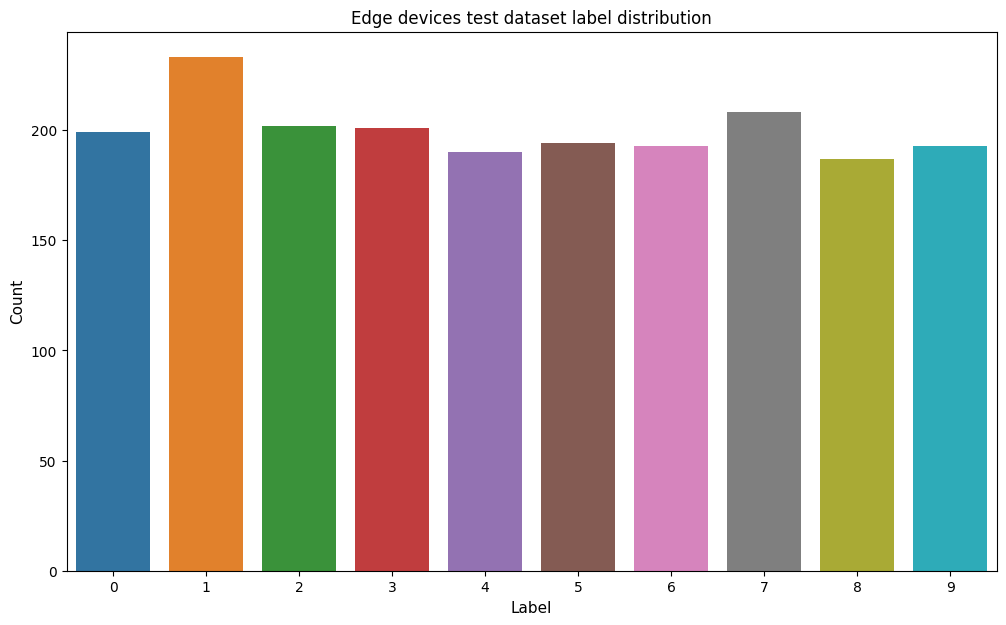

In [3]:
_, x_test_edge, _, y_test_edge = train_test_split(x_test, y_test, test_size=0.2, random_state=80)

fig, axes = plt.subplots(1, 1, figsize=(12, 7))

# Visualization of validation dataset label distribution
data = pd.DataFrame(y_test_edge, columns=['label'])
chart = sns.countplot(x=data['label'].sort_values(), ax=axes)
axes.set_title('Edge devices test dataset label distribution', fontsize=12)
axes.set_xlabel("Label", fontsize=11)
axes.set_ylabel("Count", fontsize=11)
plt.show()

##### &emsp;&emsp;1.2.2 Displaying some training images and labels.

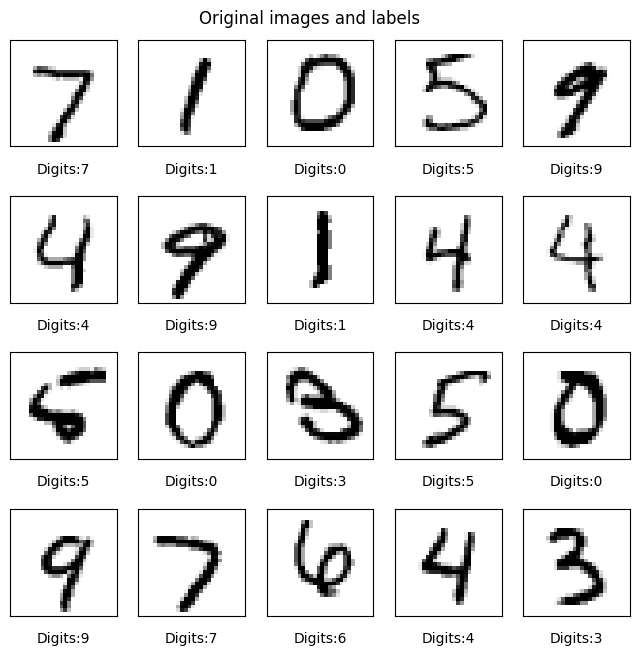

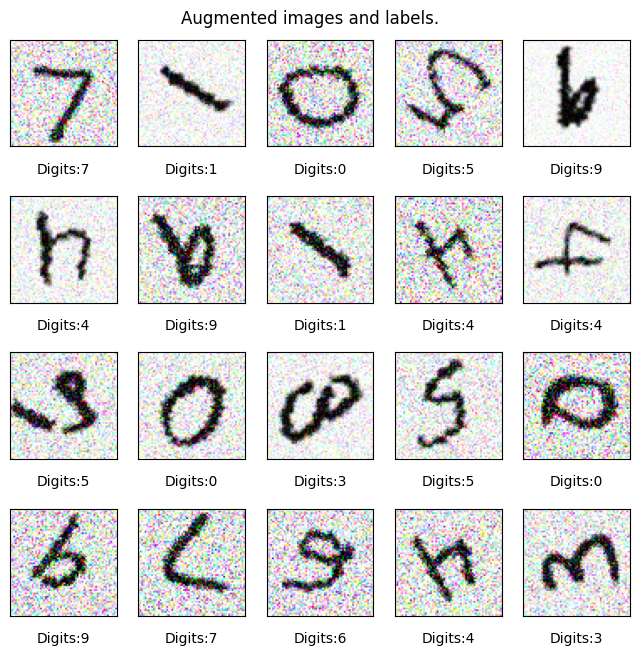

In [4]:
row, col = 4, 5
fig, axes = plt.subplots(row, col, figsize=(8, 7))

# Output 20 test images and their labels.
fig.subplots_adjust(top=0.94, hspace=0.4)
fig.suptitle("Original images and labels")
for i in range(col):
    for j in range(row):
        axes[j][i].set_xlabel(str("Digits:{}".format(y_test1[i*col+j*row])), fontsize=10)
        axes[j][i].set_xticklabels([])
        axes[j][i].set_yticklabels([])
        axes[j][i].tick_params(bottom=False, left=False, top=False, right=False)
        axes[j][i].imshow(x_test1[i*col+j*row], cmap='gray_r')

row, col = 4, 5
fig, axes = plt.subplots(row, col, figsize=(8, 7))

# Output 20 augmented test images and their labels.
fig.subplots_adjust(top=0.94, hspace=0.4)
fig.suptitle("Augmented images and labels.")
for i in range(col):
    for j in range(row):
        axes[j][i].set_xlabel(str("Digits:{}".format(y_test[i*col+j*row])), fontsize=10)
        axes[j][i].set_xticklabels([])
        axes[j][i].set_yticklabels([])
        axes[j][i].tick_params(bottom=False, left=False, top=False, right=False)
        axes[j][i].imshow(x_test[i*col+j*row], cmap='gray_r')

plt.show()

##### &emsp;&emsp;1.2.3 Functions: Plotting learning curves, confusion matrix and classification report.

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# Functions: Plotting learning curves
def plot_learning_curves(historys,epochs,batch_size):
    fig,ax = plt.subplots(1,2,figsize=(18,9))

    history = historys.history

    x_len = len(history['loss'])
    x = np.linspace(1,x_len, x_len)
    # Plot out the loss and the val_loss
    axes = ax[0]
    axes.plot(x, history['loss'], marker='o', label='loss',)
    axes.plot(x, history['val_loss'], marker='o', label='val_loss')
    axes.plot(x[epochs-1], history['val_loss'][epochs-1], marker='o', markersize=7, color='b')
    axes.set_title('best epochs ={}, batch_size={}'.format(epochs,batch_size),fontsize=12)
    axes.set_xlabel('epochs',fontsize=12)
    axes.set_ylabel('loss',fontsize=12)
    axes.legend(fontsize=12)
    axes.grid()

    # Plot out the accuracy and  the val_accuracy
    axes = ax[1]
    axes.plot(x, history['accuracy'], marker='o', label='accuracy')
    axes.plot(x, history['val_accuracy'], marker='o', label='val_accuracy')
    axes.plot(x[epochs-1], history['val_accuracy'][epochs-1], marker='o', markersize=7, color='r')
    axes.set_title('best epochs ={}, batch_size={}'.format(epochs,batch_size),fontsize=12)
    axes.set_xlabel('epochs',fontsize=12)
    axes.set_ylabel('accuracy',fontsize=12)
    axes.legend(fontsize=12)
    axes.grid()
    
# print report  and confusion matrix
def report_matrix(y_test, y_pred, num=0, title='',pred_time=0):
    
    print("\nthe number of pictures: {}".format(num))
    print("\nthe pediction time (second): {:.3f}".format(pred_time/1000))
    print("\nthe classification report{}:".format(title))
    print(classification_report(y_test,y_pred))
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # plot the confusion matrix
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.title('Confusion matrix{}'.format(title))
    plt.show()


### Part 2. CNN Model and Evaluation.

#### &emsp;2.1. Model and Evaluation on PC.
   
##### &emsp;&emsp;2.1.1 Building a multi-layer convolutional neural network.

In [6]:
# define model name
model_name = "MNIST_CNN"

# Create directory
dir_name = ['Data_Test',
            'Results',
            'Model_H5_PB',
            'Model_Tensorflow_Lite',
            'Model_Openvino_IR']
for dname in dir_name:
    if not os.path.exists(dname):
        os.makedirs(dname)
#
tflite_path = dir_name[3]
result_path = dir_name[1]

# test data (numpy format) filename
test_X_data_filename ="Data_Test/test_data_{}".format(model_name)
test_y_data_filename ="Data_Test/test_data_y_{}".format(model_name)

# Model filename
h5_file ="Model_H5_PB/{}".format(model_name)
pb_file = "Model_H5_PB/{}_PB".format(model_name)
tflite_file = 'Model_Tensorflow_Lite/{}'.format(model_name)
ir_file = "Model_Openvino_IR/{}_IR".format(model_name)


In [7]:
# The code defines a function `create_cnn()`
# that creates a convolutional neural network (CNN) model using the Keras Sequential API. 
# The CNN model consists of several layers including convolutional layers, pooling layers, 
# batch normalization layers, dropout layers, and fully connected layers. 
# The function returns the created CNN model.
def create_cnn(name="sequential", hidden_layer=[(128,0.2)]):
    cnn_model = tf.keras.models.Sequential(name=name)
    
    # input layer
    cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # hidden layer
    for (filters,rate)in hidden_layer:
        # second convolutional layer
        cnn_model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=3, activation='relu'))
        # Pooling
        cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
        # batch_normalization layer  
        # cnn_model.add(tf.keras.layers.BatchNormalization())
        # Adding Dropout layer
        cnn_model.add(tf.keras.layers.Dropout(rate=rate))
    
    # Flattening
    cnn_model.add(tf.keras.layers.Flatten())
    # Full Connection
    cnn_model.add(tf.keras.layers.Dense(units=64, activation='relu'))
    # Output Layer
    cnn_model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
        
    return cnn_model

# cnn_hidden_layer=[(128, 0.1),(64, 0.1),(64, 0.1)]
cnn_hidden_layer=[(128, 0.2)]
cnn_optimizer ='SGD'

# create cnn model
# cnn_model = create_cnn(name=model_name, hidden_layer=[(128, 0.1),(64, 0.1),(64, 0.1)])
# create cnn model
cnn_model = create_cnn(name=model_name, hidden_layer=cnn_hidden_layer)
cnn_model.compile(optimizer=cnn_optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Get the total number of parameters of the model
total_params = np.array(tf.reduce_sum([tf.reduce_prod(var.shape) for var in cnn_model.trainable_variables])).item()

# the cnn model description
cnn_model.summary()

Model: "MNIST_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       36992     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 128)       0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 64)                7372864   
                                                         

##### &emsp;&emsp;2.1.2 Training the model and tuning parameters.

In [8]:
# Create ModelCheckpoint callback to save best model
checkpoint_filepath = 'best_model.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=model_verbose
)

# define the grid search parameters
# parameters = {'epochs': 15, 'batch_size': [8,16, 32, 64, 96]}
parameters = {'epochs': 21, 'batch_size': [8]}

best_epochs = 0 
best_batch_size = 0
best_val_acc = 0
best_historys = ''

# search over specified parameter values for an estimator.
for batch_size in parameters['batch_size']:
    # create cnn model
    historys = cnn_model.fit(x_train, y_train, epochs=parameters['epochs'], batch_size=batch_size, 
                            validation_data=(x_val, y_val), callbacks=[checkpoint_callback],verbose = model_verbose)
    
    tf.keras.backend.clear_session()
    
    val_acc = historys.history['val_accuracy']
    if max(val_acc) > best_val_acc:
        best_val_acc =  max(val_acc)
        max_index =  val_acc.index(best_val_acc)
        best_epochs = max_index + 1 
        best_batch_size = batch_size
        best_historys = historys

# Move best model file
os.replace(checkpoint_filepath, h5_file+".h5")

Epoch 1/21
5992/6000 [============================>.] - ETA: 0s - loss: 1.6443 - accuracy: 0.3992
Epoch 1: val_accuracy improved from -inf to 0.66675, saving model to best_model.h5
6000/6000 [==============================] - 34s 5ms/step - loss: 1.6434 - accuracy: 0.3995 - val_loss: 1.0234 - val_accuracy: 0.6668
Epoch 2/21
5997/6000 [============================>.] - ETA: 0s - loss: 0.6096 - accuracy: 0.8053
Epoch 2: val_accuracy improved from 0.66675 to 0.85875, saving model to best_model.h5
6000/6000 [==============================] - 32s 5ms/step - loss: 0.6096 - accuracy: 0.8052 - val_loss: 0.4490 - val_accuracy: 0.8587
Epoch 3/21
5994/6000 [============================>.] - ETA: 0s - loss: 0.3285 - accuracy: 0.8983
Epoch 3: val_accuracy improved from 0.85875 to 0.88525, saving model to best_model.h5
6000/6000 [==============================] - 32s 5ms/step - loss: 0.3284 - accuracy: 0.8983 - val_loss: 0.3620 - val_accuracy: 0.8852
Epoch 4/21
5989/6000 [===========================

##### &emsp;&emsp;2.1.3 Generating and saving the best model with optimal parameters, learning curves and classification report.

&emsp;&emsp;&emsp; Generating and saving the best model with optimal parameters.

In [9]:
# Saving the model to .pb format
final_cnn_model = tf.keras.models.load_model(h5_file+".h5")
tf.saved_model.save(final_cnn_model, pb_file)

INFO:tensorflow:Assets written to: Model_H5_PB/MNIST_CNN_PB\assets


INFO:tensorflow:Assets written to: Model_H5_PB/MNIST_CNN_PB\assets


&emsp;&emsp;&emsp; Plotting learning curves.

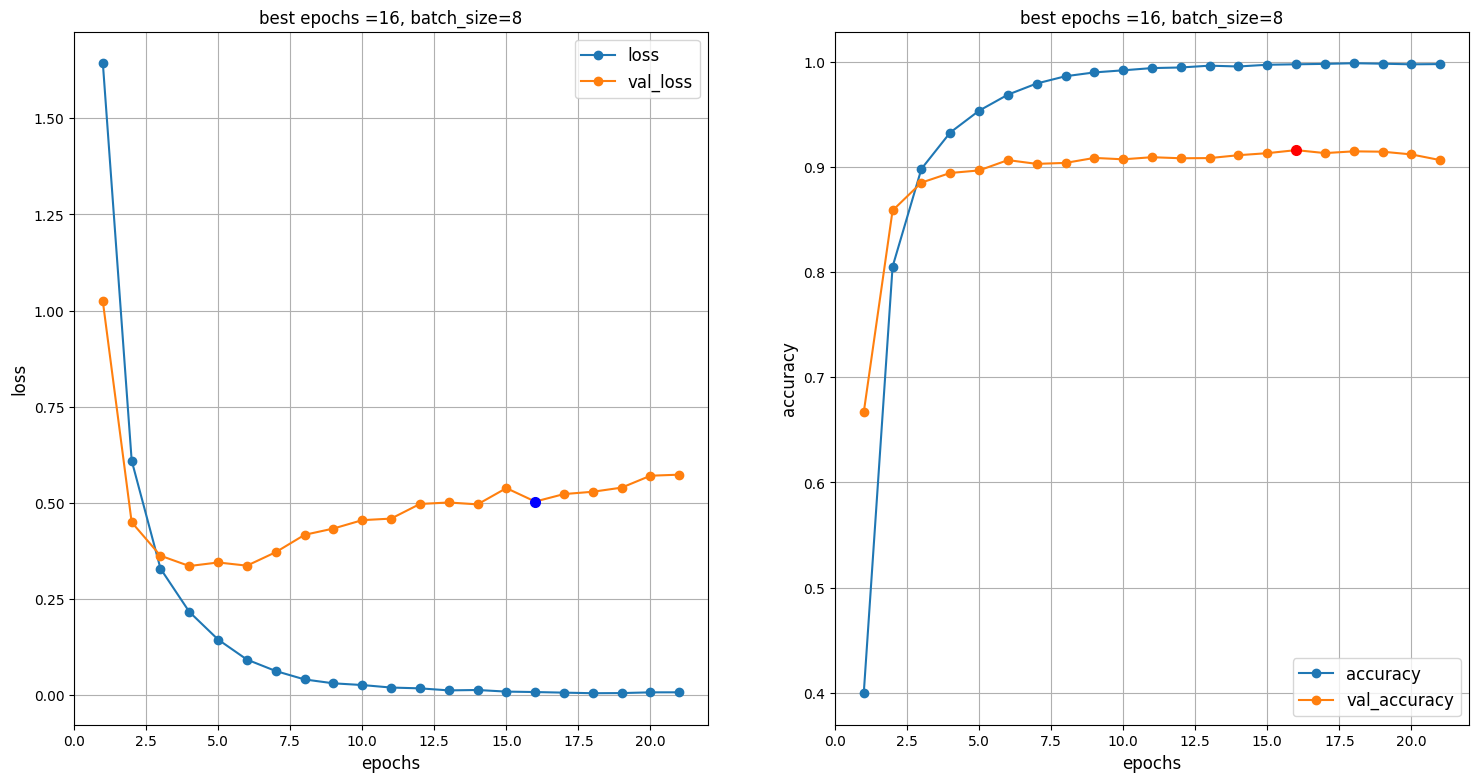

In [10]:
# Plotting learning curves.
plot_learning_curves(best_historys,best_epochs,best_batch_size)

&emsp;&emsp;&emsp;  Generating a confusion matrix and classification report.

1250/1250 [==============================] - 2s 2ms/step

the number of pictures: 10000

the pediction time (second): 0.003

the classification report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       980
           1       0.97      0.99      0.98      1135
           2       0.92      0.90      0.91      1032
           3       0.93      0.94      0.94      1010
           4       0.87      0.93      0.90       982
           5       0.92      0.89      0.91       892
           6       0.93      0.92      0.92       958
           7       0.88      0.89      0.89      1028
           8       0.92      0.89      0.90       974
           9       0.92      0.87      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



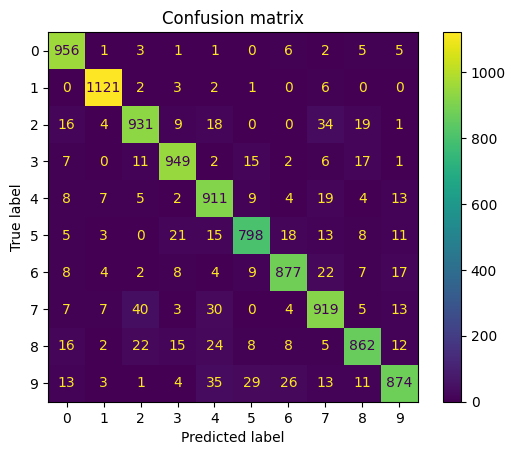

In [11]:
from datetime import datetime

# predict
start_time = datetime.now()
y_pred = (final_cnn_model.predict(x_test, batch_size = best_batch_size, verbose = model_verbose)>0.5).astype(int)
y_pred_labels = tf.argmax(y_pred, axis=1)
end_time = datetime.now()

# calculating the time it takes to run the code.
pred_time = np.array((end_time - start_time).total_seconds())

# print report  and plot confusion matrix    
report_matrix(y_test,y_pred_labels,num=y_pred_labels.shape[0],pred_time=pred_time)

# record model_status
# acc = accuracy_score(y_test, y_pred_labels)

##### &emsp;&emsp;2.1.4 Quantization Aware Training with Optimization Toolkit, learning curves and classification report.

&emsp;&emsp;&emsp; Quantization Aware Training with TensorFlow Model Optimization Toolkit - Performance with Accuracy

In [12]:
import tensorflow_model_optimization as tfmot

# Create ModelCheckpoint callback to save best model
checkpoint_filepath = 'best_model.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=model_verbose
)

# create cnn model
cnn_model = create_cnn(name=model_name+"_quant_aware", hidden_layer=cnn_hidden_layer)

# Quantize the entire model.
quantized_model = tfmot.quantization.keras.quantize_model(cnn_model)

# Continue with training as usual.
quantized_model.compile(optimizer=cnn_optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
historys = quantized_model.fit(x_train, y_train, epochs=best_epochs, batch_size=best_batch_size, 
                            validation_data=(x_val, y_val), callbacks=[checkpoint_callback],verbose = model_verbose)

Epoch 1/16
5997/6000 [============================>.] - ETA: 0s - loss: 1.4145 - accuracy: 0.5001
Epoch 1: val_accuracy improved from -inf to 0.74042, saving model to best_model.h5
6000/6000 [==============================] - 79s 13ms/step - loss: 1.4145 - accuracy: 0.5002 - val_loss: 0.8020 - val_accuracy: 0.7404
Epoch 2/16
5999/6000 [============================>.] - ETA: 0s - loss: 0.6103 - accuracy: 0.8072
Epoch 2: val_accuracy improved from 0.74042 to 0.85633, saving model to best_model.h5
6000/6000 [==============================] - 78s 13ms/step - loss: 0.6102 - accuracy: 0.8072 - val_loss: 0.4554 - val_accuracy: 0.8563
Epoch 3/16
6000/6000 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8886
Epoch 3: val_accuracy improved from 0.85633 to 0.89292, saving model to best_model.h5
6000/6000 [==============================] - 78s 13ms/step - loss: 0.3622 - accuracy: 0.8886 - val_loss: 0.3480 - val_accuracy: 0.8929
Epoch 4/16
5997/6000 [========================

&emsp;&emsp;&emsp; Generating and saving the best model with optimal parameters.

In [13]:
# Move best model file
os.replace(checkpoint_filepath, h5_file + "_quant_aware" + ".h5")

# Saving the model to .pb format
tf.saved_model.save(quantized_model, pb_file + "_quant_aware")

INFO:tensorflow:Assets written to: Model_H5_PB/MNIST_CNN_PB_quant_aware\assets


INFO:tensorflow:Assets written to: Model_H5_PB/MNIST_CNN_PB_quant_aware\assets


&emsp;&emsp;&emsp; Plotting learning curves.

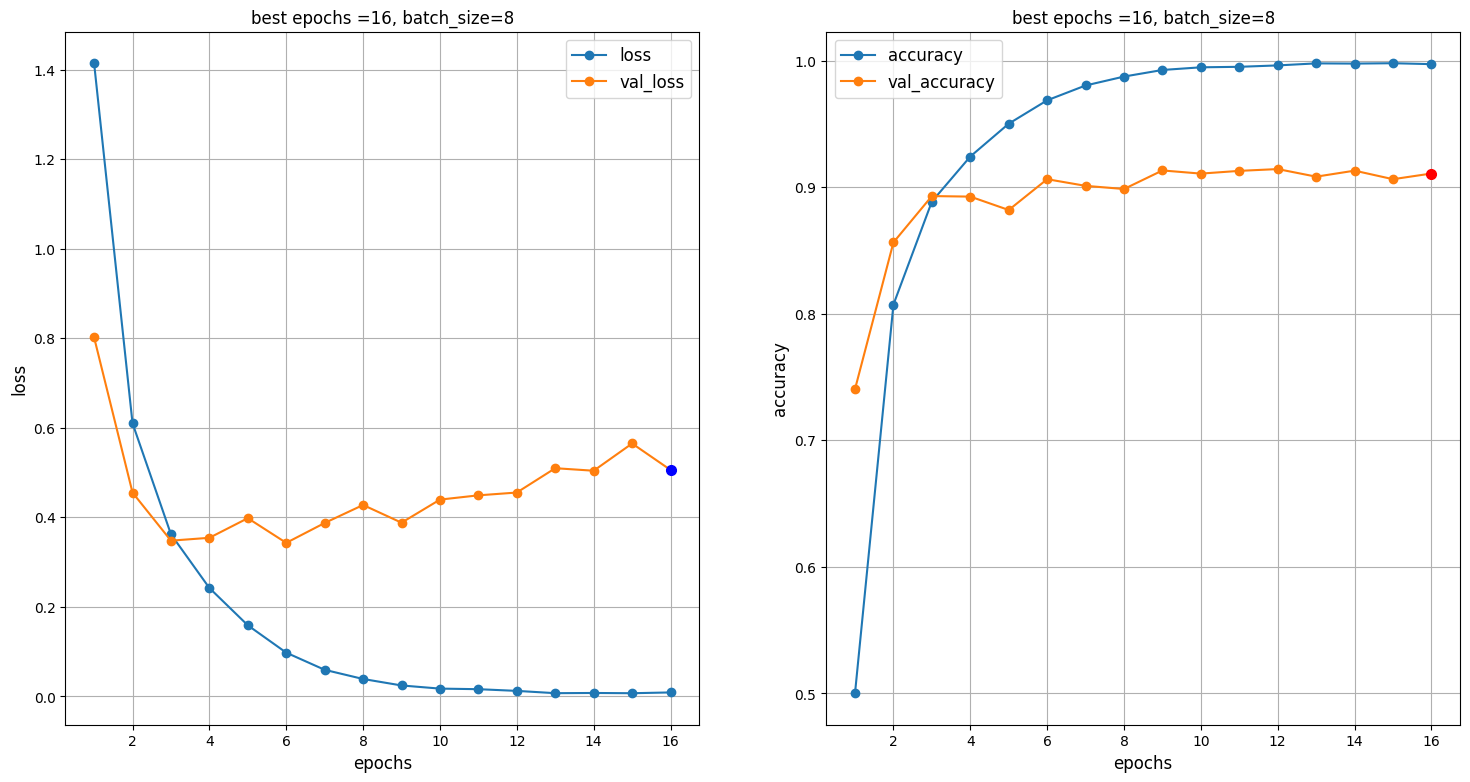

In [14]:
# Plotting learning curves.
plot_learning_curves(historys,best_epochs,best_batch_size)

&emsp;&emsp;&emsp;  Generating a confusion matrix and classification report.

1250/1250 [==============================] - 4s 3ms/step

the number of pictures: 10000

the pediction time (second): 0.004

the classification report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       980
           1       0.97      0.99      0.98      1135
           2       0.91      0.89      0.90      1032
           3       0.94      0.91      0.92      1010
           4       0.91      0.89      0.90       982
           5       0.91      0.88      0.90       892
           6       0.91      0.90      0.90       958
           7       0.87      0.90      0.88      1028
           8       0.94      0.86      0.90       974
           9       0.85      0.90      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



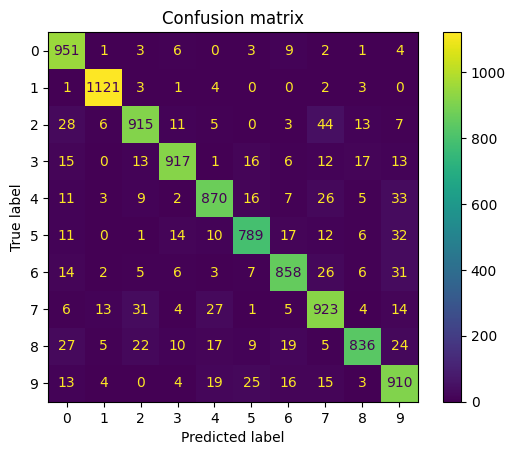

In [16]:
from datetime import datetime

# predict
start_time = datetime.now()
y_pred = (quantized_model.predict(x_test, batch_size = best_batch_size ,verbose = model_verbose)>0.5).astype(int)
y_pred_labels = tf.argmax(y_pred, axis=1)
end_time = datetime.now()

# calculating the time it takes to run the code.
pred_time = np.array((end_time - start_time).total_seconds())

# print report  and plot confusion matrix    
report_matrix(y_test,y_pred_labels,num=y_pred_labels.shape[0],pred_time=pred_time)

# record model_status
# acc = accuracy_score(y_test, y_pred_labels)

#### &emsp;2.2 TensorFlow Lite Model on Raspberry Pi.

##### &emsp;&emsp;2.2.1 Generating the Lite model and test data

In [12]:
# Save the test data 
np.save(test_X_data_filename, x_test_edge)
np.save(test_X_data_filename+"_uint8", (x_test_edge*255).astype(np.uint8))
np.save(test_X_data_filename+"_float16", x_test_edge.astype(np.float16))
np.save(test_y_data_filename, y_test_edge)

# Load the TensorFlow model. 
convert_model = tf.keras.models.load_model(h5_file+".h5")

################## No quantification ##################
# Convert the TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(convert_model)
tflite_model = converter.convert()
# Save the TensorFlow Lite model.
with open(tflite_file+".tflite", 'wb') as f:
  f.write(tflite_model)

################## Dynamic range quantization ##################
# Convert the TensorFlow Lite model with quantization.
converter = tf.lite.TFLiteConverter.from_keras_model(convert_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
# Save the TensorFlow Lite model with quantization.
with open(tflite_file+"_quant.tflite", 'wb') as f:
  f.write(tflite_quant_model)

################## Full integer quantization ##################
## Convert the TensorFlow Lite model with integer quantization.
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(100):
    yield [input_value]
    
converter = tf.lite.TFLiteConverter.from_keras_model(convert_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_quant_uint8_model = converter.convert()
# Save the TensorFlow Lite model with integer quantization.
with open(tflite_file+"_quant_uint8.tflite", 'wb') as f:
  f.write(tflite_quant_uint8_model)

################## Float16 quantization ##################
## Convert the TensorFlow Lite model with float16 quantization.
converter = tf.lite.TFLiteConverter.from_keras_model(convert_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_float16_model = converter.convert()
# Save the TensorFlow Lite model with float16 quantization.
with open(tflite_file+"_quant_float16.tflite", 'wb') as f:
  f.write(tflite_quant_float16_model)

################## Quantization Aware Training with Toolkit ##################
## Convert the TensorFlow Lite model wite Quantization Aware Training.
converter = tf.lite.TFLiteConverter.from_keras_model(convert_model)
tflite_model = converter.convert()
# Save the TensorFlow Lite model.
with open(tflite_file + "_quant_aware" + ".tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpg2rxlu4h\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpg2rxlu4h\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp9iu0qo2v\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp9iu0qo2v\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp5z16n4no\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp5z16n4no\assets
c:\ProgramDev\miniconda3\envs\openvino\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpphpzm6if\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmpphpzm6if\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp1v8echl8\assets


INFO:tensorflow:Assets written to: C:\Users\ADMINI~1\AppData\Local\Temp\tmp1v8echl8\assets


In [7]:
# Write command line to file
def write_command(file, model_file, xdata_file, ydata_file, out_dir, title):
    file.write('python3  ./model_run.py \\\n --model ./{} \\\n --xdata ./{} \\\n --ydata ./{} \\\n --outdir ./{} \\\n --title {}\n\n'
               .format(model_file, xdata_file, ydata_file, out_dir, title))

# creating a shell script file named "run_tflite.sh" and writing commands to it.
with open('run_tflite.sh', 'w', newline='\n') as file:
    file.write("#!/bin/bash\n\n")
    
    write_command(file, tflite_file+".tflite", test_X_data_filename+".npy", 
                  test_y_data_filename+".npy", result_path, "'No quantification'")
    
    write_command(file, tflite_file+"_quant_aware.tflite", test_X_data_filename+".npy", 
                  test_y_data_filename+".npy", result_path, "'Quantization Aware Training'")
    
    write_command(file, tflite_file+"_quant.tflite", test_X_data_filename+".npy", 
                  test_y_data_filename+".npy", result_path, "'Dynamic range quantization'")

    write_command(file, tflite_file+"_quant_float16.tflite", test_X_data_filename+"_float16.npy", 
                  test_y_data_filename+".npy", result_path, "'Float16 quantization'")
    
    write_command(file, tflite_file+"_quant_uint8.tflite", test_X_data_filename+"_uint8.npy", 
                  test_y_data_filename+".npy", result_path, "'Full integer quantization'")


##### &emsp;&emsp;2.2.2. Running the model on hardware environment and recording the results

+ Transfer the files `model_run.py` and `run_tflite.sh`, the directorys `Model_Tensorflow_Lite`  and `Data_Test`to the Raspberry Pi's system.

+ Run the `run_tflite.sh` script on the Raspberry Pi.
```shell
   ./ run_tflite.sh
```
+ Once the script has finished running,   the files `*.json` to the directory `Results` will be generated.
+ Copy the directory `Results` to the directory where the MNIST_model.ipynb notebook is located.

##### &emsp;&emsp;2.2.3. Generating a report based on the experimental results

,1,2,3,4,5
Type,No quantification,Quantization Aware Training,Float16 quantization,Dynamic range quantization,Full integer quantization
Model Size,28.275 M,28.275 M,14.140 M,7.078 M,7.076 M
Accuracy,0.921,0.921,0.921,0.9215,0.9205
Inference time,88968.00 ms,93029.00 ms,90144.00 ms,63662.00 ms,57614.00 ms
Number of inferences,2000,2000,2000,2000,2000
Average Inference time,44.48 ms,46.51 ms,45.07 ms,31.83 ms,28.81 ms
Memory Usage,389.48 M,388.23 M,322.96 M,354.94 M,167.13 M
CPU Usage,60.23 %,60.96 %,62.08 %,28.16 %,25.13 %


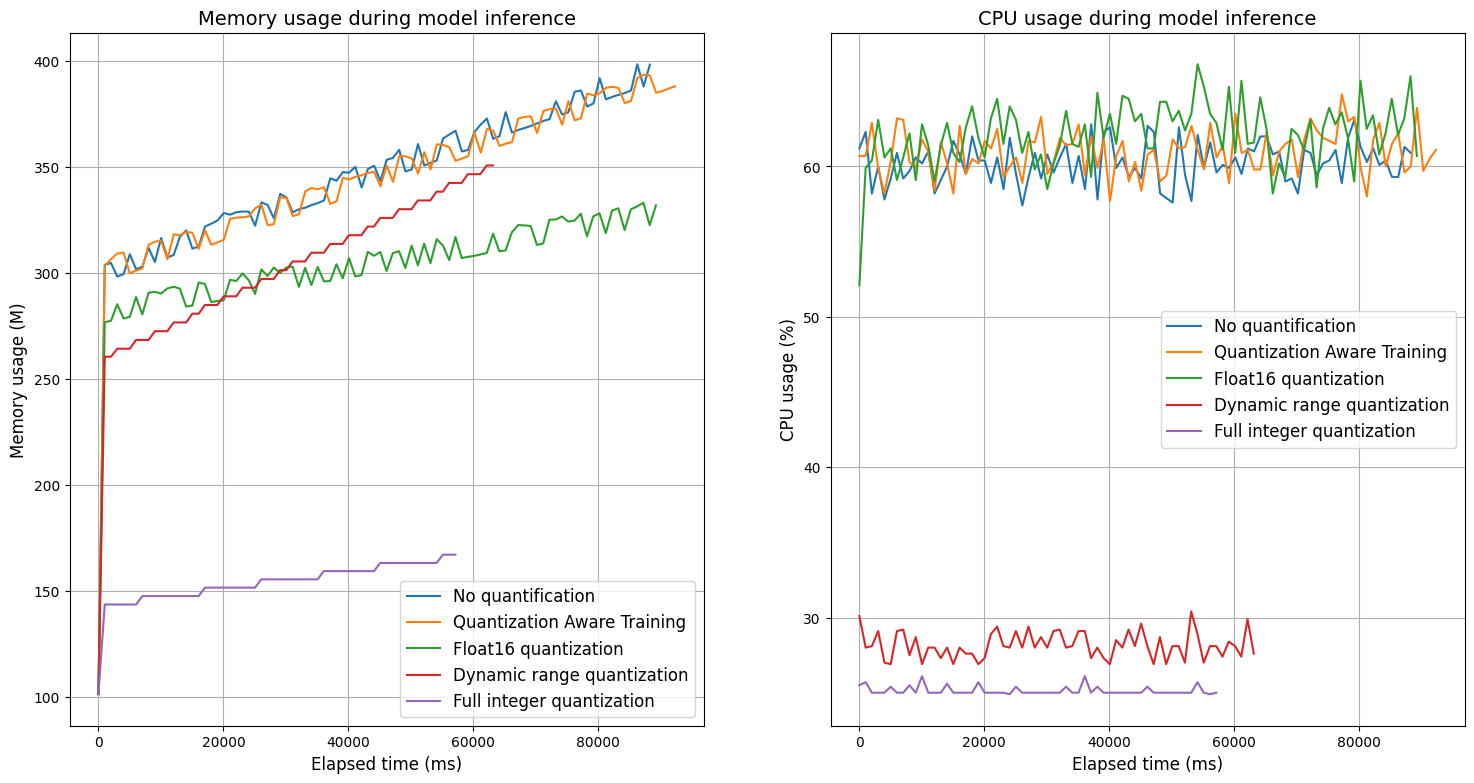

In [68]:

import json
import os.path

# Functions: Plotting cpu and memory usage curves
def plot_usage_curves(plot_data):
    fig,ax = plt.subplots(1,2,figsize=(18,9))

    # 
    axes = ax[0]
    for key,value in plot_data.items():
        x,y = value[0],value[1]
        axes.plot(x, y, label=key)
    axes.set_title('Memory usage during model inference',fontsize=14)
    axes.set_xlabel('Elapsed time (ms)',fontsize=12)
    axes.set_ylabel('Memory usage (M)',fontsize=12)
    axes.legend(fontsize=12)
    axes.grid()

    # Plot out the accuracy and  the val_accuracy
    axes = ax[1]
    for key,value in plot_data.items():
        x,y = value[0],value[2]
        axes.plot(x, y, label=key)
    axes.set_title('CPU usage during model inference',fontsize=14)
    axes.set_xlabel('Elapsed time (ms)',fontsize=12)
    axes.set_ylabel('CPU usage (%)',fontsize=12)
    axes.legend(fontsize=12)
    axes.grid()
    
def plot_model_usage_curves(mname_list, title_repl={}):
    plot_data = {}
    for m_name in mname_list:
        # the file name of the prediction result.
        json_data_file = "./Results/{}_result.json".format(m_name)

        if os.path.isfile(json_data_file):
            with open(json_data_file, "r", encoding="utf-8") as file:
                data = json.load(file)
        
            title = data["title"]
            if title in title_repl:
                title = title_repl[title]
            plot_data[title] = np.array([data["elapsed time"],data["mem usage"],data["cpu usage"]])
                        
        
    plot_usage_curves(plot_data)
        

def evaluate_model(m_name, id="1", m_type=""):
    # the file name of the prediction result.
    json_data_file = "./Results/{}_result.json".format(m_name)

    if os.path.isfile(json_data_file):
        # 
        with open(json_data_file, "r", encoding="utf-8") as file:
            data = json.load(file)

        model_size = 0
        tfmodel_file = "./{}/{}.tflite".format(tflite_path,m_name)
        if os.path.exists(tfmodel_file):
            model_size = "{:.3f} M".format(os.path.getsize(tfmodel_file)/(1024*1024))
        else:
            model_size  = os.path.getsize("./{}/{}.xml".format(ir_file,m_name))
            model_size += os.path.getsize("./{}/{}.bin".format(ir_file,m_name))
            model_size += os.path.getsize("./{}/{}.mapping".format(ir_file,m_name))
            model_size = "{:.3f} M".format(model_size/(1024*1024))

        if m_type == "":
            m_type = data["title"]
        # 
        model_status [id] = {"Type" : m_type,
                             "Model Size"   : model_size,
                             "Accuracy"     : data["accuracy"],
                             "Inference time" :  "{:.2f} ms".format(data["inference time"]),
                             "Number of inferences" : data["number of inferences"],
                             "Average Inference time" :  "{:.2f} ms".format(data["average inference time"]),
                             "Memory Usage" : "{:.2f} M".format(data["memory usage"]),
                             "CPU Usage"    : "{:.2f} %".format(round(np.mean(np.array(data["cpu usage"])),2))
                            }
        
#
mname_list=[model_name,
            model_name+"_quant_aware",
            model_name+"_quant_float16",
            model_name+"_quant",
            model_name+"_quant_uint8"]

# Evaluation Model
model_status = {}
evaluate_model(m_name=mname_list[0], id="1")
evaluate_model(m_name=mname_list[1], id="2")
evaluate_model(m_name=mname_list[2], id="3")
evaluate_model(m_name=mname_list[3], id="4")
evaluate_model(m_name=mname_list[4], id="5")

#
plot_model_usage_curves(mname_list)

# Results
df = pd.DataFrame(model_status)
# print(df.to_markdown())
df

#### &emsp;2.3 Intel OpenVINO IR Model on Raspberry Pi + Intel Neural Compute Stick 

##### &emsp;&emsp;2.3.1. Generating the IR model and test data

In [31]:
from IPython.display import Markdown

str_inupt_shape = "{},{},{},{}".format(1,input_shape[0],input_shape[1],input_shape[2])

mo_command = 'mo --saved_model_dir "{}" --input_shape "[{}]" \
    --model_name "{}_IR" --compress_to_fp16 --output_dir "{}"'.format(pb_file, str_inupt_shape, model_name, ir_file)

display(Markdown(f"`{mo_command}`"))

print("Exporting TensorFlow model to IR... This may take a few minutes.")
! $mo_command


`mo --saved_model_dir "Model_H5_PB/MNIST_CNN_PB" --input_shape "[1,64,64,3]"     --model_name "MNIST_CNN_IR" --compress_to_fp16 --output_dir "Model_Openvino_IR/MNIST_CNN_IR"`

Exporting TensorFlow model to IR... This may take a few minutes.
[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: d:\My Soft\Python\6709\Project\MNIST_Model\Model_Openvino_IR\MNIST_CNN_IR\MNIST_CNN_IR.xml
[ SUCCESS ] BIN file: d:\My Soft\Python\6709\Project\MNIST_Model\Model_Openvino_IR\MNIST_CNN_IR\MNIST_CNN_IR.bin


In [11]:
# creating a shell script file named "run_ir.sh" and writing commands to it.
with open('run_ir.sh', 'w', newline='\n') as file:
    file.write("#!/bin/bash\n\n")
    
    write_command(file, ir_file+'/'+model_name+'_IR.xml', test_X_data_filename+".npy", 
                  test_y_data_filename+".npy", result_path, "'Accelerated with intel NCS2'")    

##### &emsp;&emsp;2.3.2. Running the model on hardware environment and recording the results

+ Transfer the files `model_run.py` and `run_ir.sh`, the directorys `Model_Openvino_IR`  and `Data_Test`to the Raspberry Pi's system.

+ Run the `run_ir.sh` script on the Raspberry Pi.
```shell
   ./ run_ir.sh
```
+ Once the script has finished running,   the files `*.json` to the directory `Results` will be generated.
+ Copy the directory `Results` to the directory where the MNIST_model.ipynb notebook is located.

##### &emsp;&emsp;2.3.3. Generating a report based on the experimental results

|                        | 1               | 2                           |
|:-----------------------|:----------------|:----------------------------|
| Type                   | Raspberry Pi 4B | Accelerated with intel NCS2 |
| Model Size             | 28.275 M        | 14.174 M                    |
| Accuracy               | 0.921           | 0.9205                      |
| Inference time         | 88968.00 ms     | 44061.00 ms                 |
| Number of inferences   | 2000            | 2000                        |
| Average Inference time | 44.48 ms        | 22.03 ms                    |
| Memory Usage           | 389.48 M        | 410.52 M                    |
| CPU Usage              | 60.23 %         | 5.14 %                      |


,1,2
Type,Raspberry Pi 4B,Accelerated with intel NCS2
Model Size,28.275 M,14.174 M
Accuracy,0.921,0.9205
Inference time,88968.00 ms,44061.00 ms
Number of inferences,2000,2000
Average Inference time,44.48 ms,22.03 ms
Memory Usage,389.48 M,410.52 M
CPU Usage,60.23 %,5.14 %


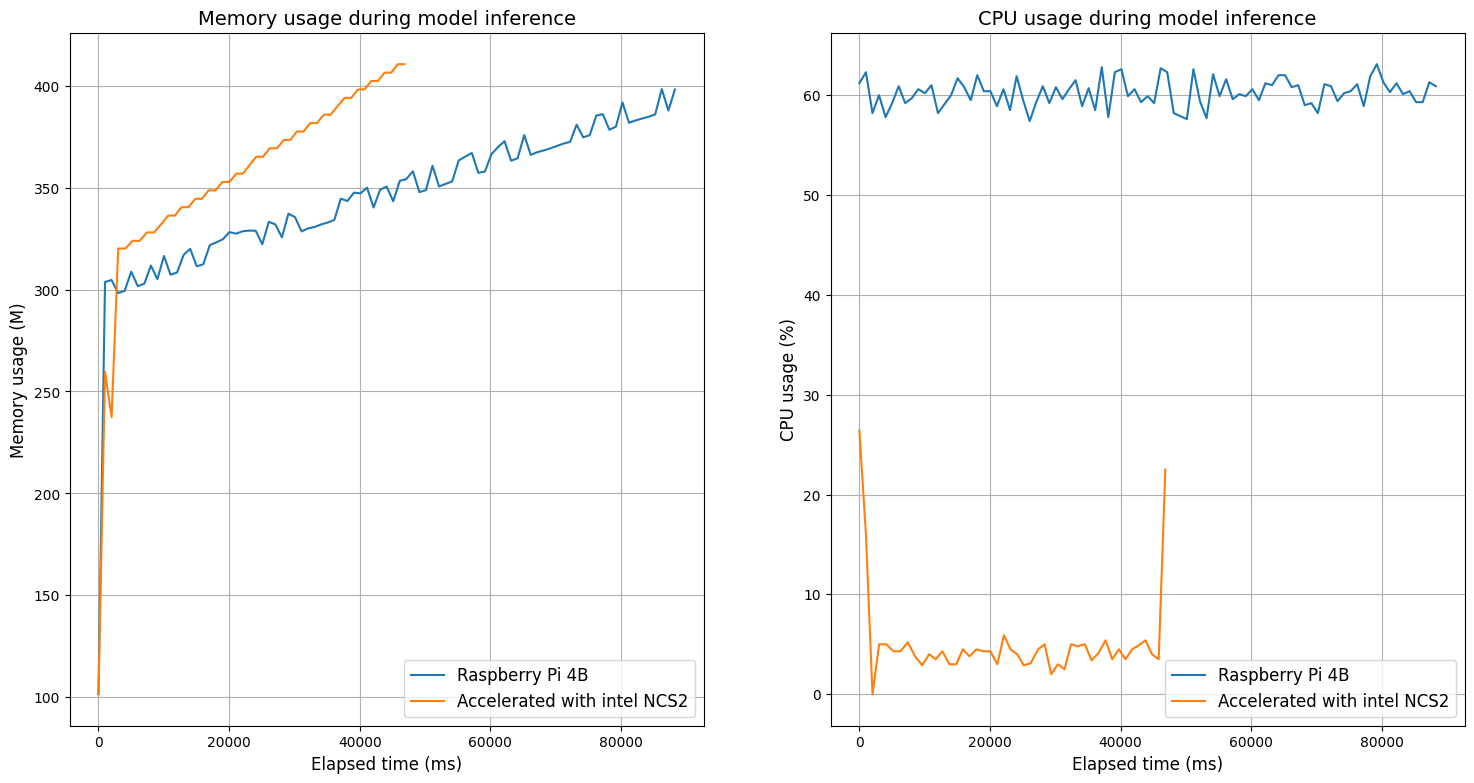

In [69]:
#
mname_list=[model_name,
            model_name+"_IR"]

# Evaluation Model
model_status = {}
evaluate_model(m_name=mname_list[0], id="1", m_type="Raspberry Pi 4B")
evaluate_model(m_name=mname_list[1], id="2")

#
plot_model_usage_curves(mname_list, {"No quantification":"Raspberry Pi 4B"})

# Results
df = pd.DataFrame(model_status)
print(df.to_markdown())
df   